In [1]:
import os
from PIL import Image
import itertools

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data_path = '/content/drive/MyDrive/Dataset/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for file in folds:
    foldpath = os.path.join(train_data_path, file)
    filelist = os.listdir(foldpath)

    for f in filelist:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        labels.append(file)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)
df

filepaths      label
0     /content/drive/MyDrive/Dataset/train/PNEUMONIA...  PNEUMONIA
1     /content/drive/MyDrive/Dataset/train/PNEUMONIA...  PNEUMONIA
2     /content/drive/MyDrive/Dataset/train/PNEUMONIA...  PNEUMONIA
3     /content/drive/MyDrive/Dataset/train/PNEUMONIA...  PNEUMONIA
4     /content/drive/MyDrive/Dataset/train/PNEUMONIA...  PNEUMONIA
...                                                 ...        ...
5249  /content/drive/MyDrive/Dataset/train/NORMAL/IM...     NORMAL
5250  /content/drive/MyDrive/Dataset/train/NORMAL/IM...     NORMAL
5251  /content/drive/MyDrive/Dataset/train/NORMAL/IM...     NORMAL
5252  /content/drive/MyDrive/Dataset/train/NORMAL/IM...     NORMAL
5253  /content/drive/MyDrive/Dataset/train/NORMAL/IM...     NORMAL

[5254 rows x 2 columns]

In [4]:
df['label'].value_counts()

label
PNEUMONIA    3903
NORMAL       1351
Name: count, dtype: int64

In [5]:
valid_data_dir = '/content/drive/MyDrive/Dataset/val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)
valid

filepaths      label
0   /content/drive/MyDrive/Dataset/val/PNEUMONIA/p...  PNEUMONIA
1   /content/drive/MyDrive/Dataset/val/PNEUMONIA/p...  PNEUMONIA
2   /content/drive/MyDrive/Dataset/val/PNEUMONIA/p...  PNEUMONIA
3   /content/drive/MyDrive/Dataset/val/PNEUMONIA/p...  PNEUMONIA
4   /content/drive/MyDrive/Dataset/val/PNEUMONIA/p...  PNEUMONIA
5   /content/drive/MyDrive/Dataset/val/PNEUMONIA/p...  PNEUMONIA
6   /content/drive/MyDrive/Dataset/val/PNEUMONIA/p...  PNEUMONIA
7   /content/drive/MyDrive/Dataset/val/PNEUMONIA/p...  PNEUMONIA
8   /content/drive/MyDrive/Dataset/val/NORMAL/NORM...     NORMAL
9   /content/drive/MyDrive/Dataset/val/NORMAL/NORM...     NORMAL
10  /content/drive/MyDrive/Dataset/val/NORMAL/NORM...     NORMAL
11  /content/drive/MyDrive/Dataset/val/NORMAL/NORM...     NORMAL
12  /content/drive/MyDrive/Dataset/val/NORMAL/NORM...     NORMAL
13  /content/drive/MyDrive/Dataset/val/NORMAL/NORM...     NORMAL
14  /content/drive/MyDrive/Dataset/val/NORMAL/NORM...     NORMAL
15  /content/drive/MyDrive/Dataset/val/NORMAL/NORM...     NORMAL

In [6]:
valid['label'].value_counts()

label
PNEUMONIA    8
NORMAL       8
Name: count, dtype: int64

In [7]:
test_data_dir = '/content/drive/MyDrive/Dataset/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for f in folds:
    foldpath = os.path.join(test_data_dir,f)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(f)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)
test

filepaths      label
0    /content/drive/MyDrive/Dataset/test/PNEUMONIA/...  PNEUMONIA
1    /content/drive/MyDrive/Dataset/test/PNEUMONIA/...  PNEUMONIA
2    /content/drive/MyDrive/Dataset/test/PNEUMONIA/...  PNEUMONIA
3    /content/drive/MyDrive/Dataset/test/PNEUMONIA/...  PNEUMONIA
4    /content/drive/MyDrive/Dataset/test/PNEUMONIA/...  PNEUMONIA
..                                                 ...        ...
624  /content/drive/MyDrive/Dataset/test/NORMAL/NOR...     NORMAL
625  /content/drive/MyDrive/Dataset/test/NORMAL/NOR...     NORMAL
626  /content/drive/MyDrive/Dataset/test/NORMAL/NOR...     NORMAL
627  /content/drive/MyDrive/Dataset/test/NORMAL/NOR...     NORMAL
628  /content/drive/MyDrive/Dataset/test/NORMAL/NOR...     NORMAL

[629 rows x 2 columns]

In [8]:
test['label'].value_counts()

label
PNEUMONIA    395
NORMAL       234
Name: count, dtype: int64

In [9]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

In [10]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4203 validated image filenames belonging to 2 classes.
Found 525 validated image filenames belonging to 2 classes.
Found 526 validated image filenames belonging to 2 classes.


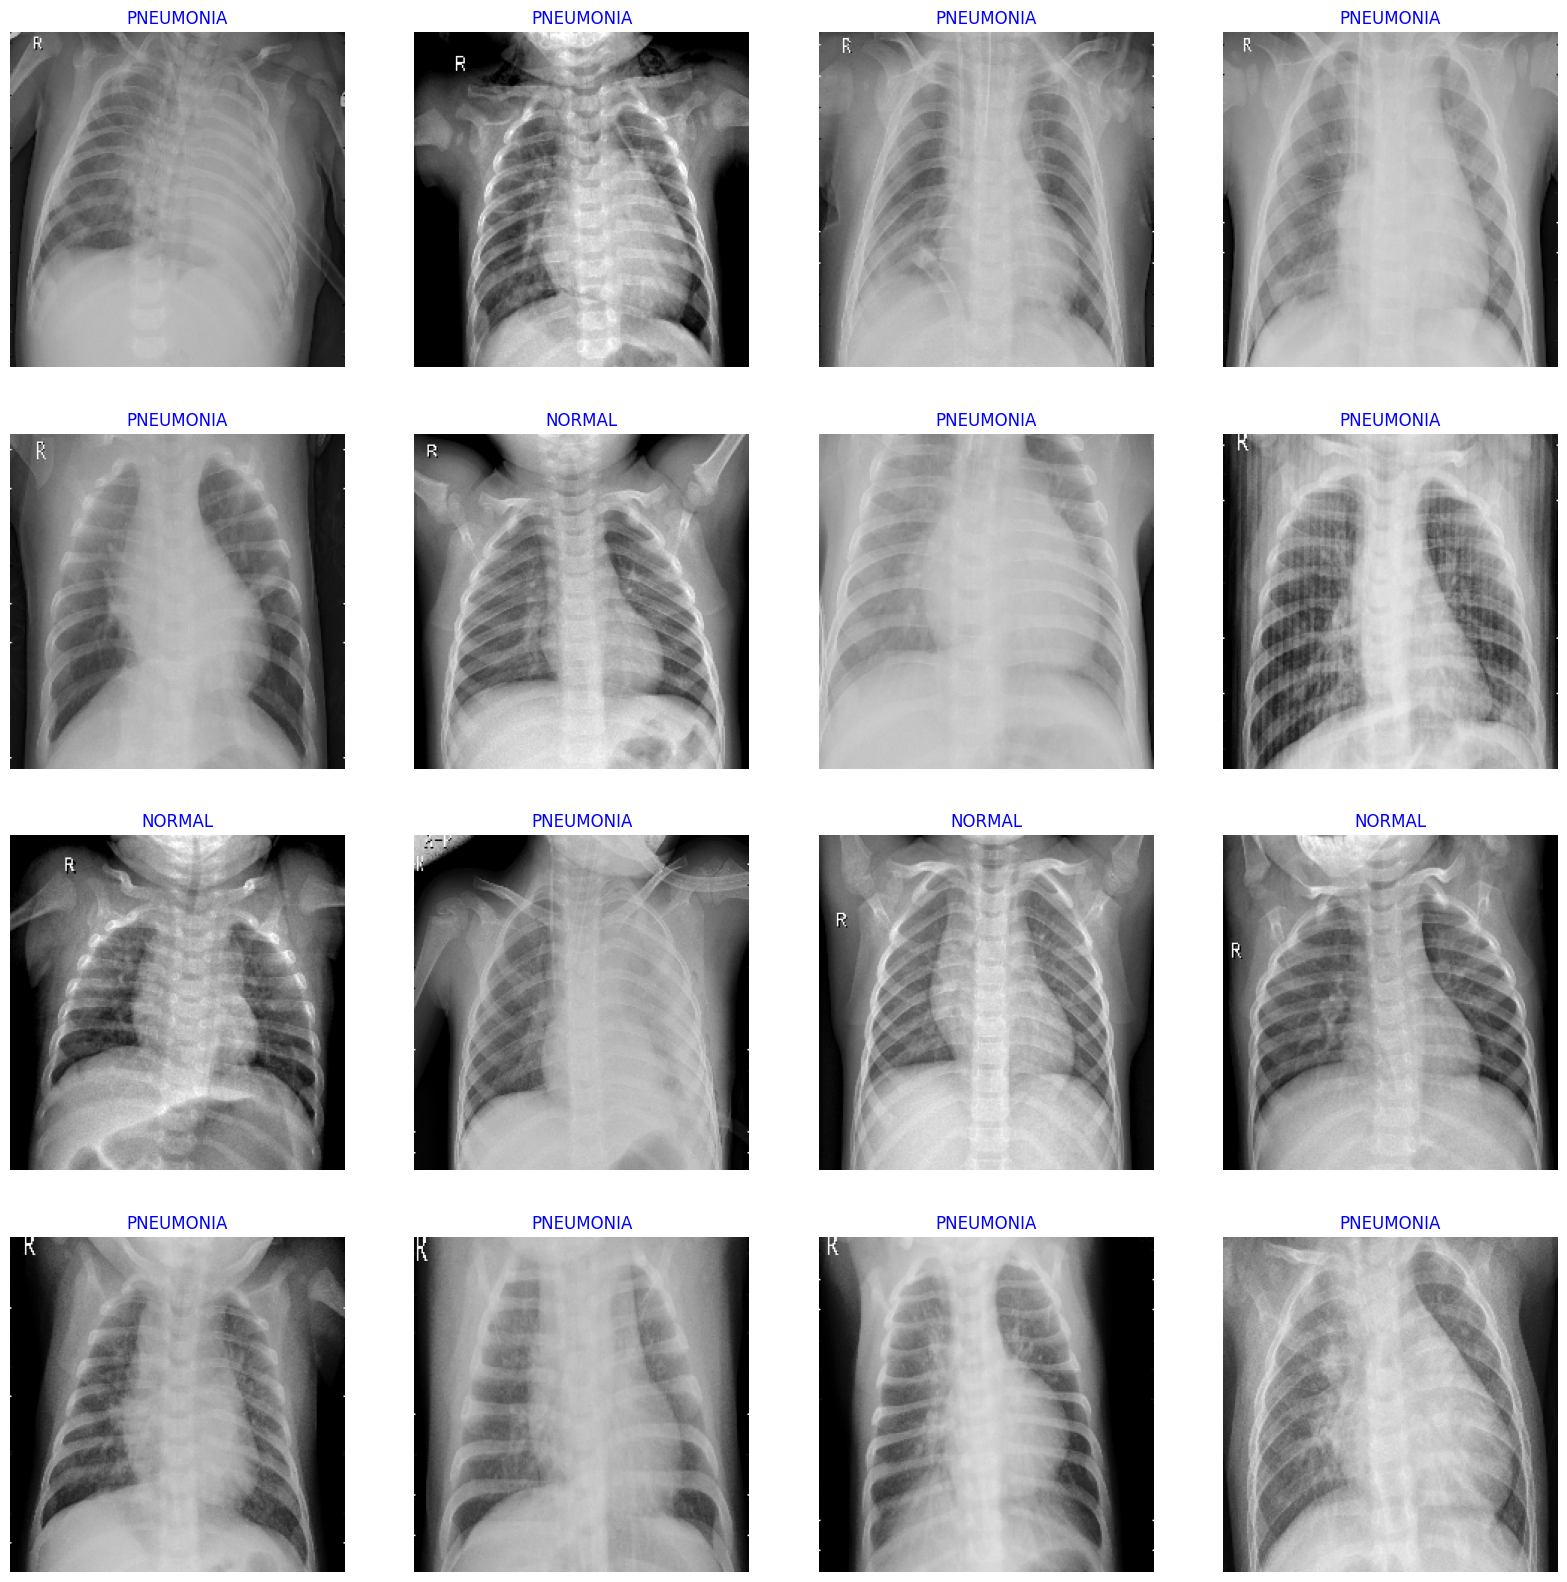

In [11]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))
    return model

model = create_cnn_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,784,162 (25.88 MB)

 Trainable params: 6,784,162 (25.88 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [14]:
epochs = 13

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/13
263/263 ━━━━━━━━━━━━━━━━━━━━ 1784s 7s/step - accuracy: 0.7196 - loss: 4.4273 - val_accuracy: 0.8152 - val_loss: 0.3836
Epoch 2/13
263/263 ━━━━━━━━━━━━━━━━━━━━ 1537s 6s/step - accuracy: 0.8575 - loss: 0.3122 - val_accuracy: 0.9352 - val_loss: 0.2047
Epoch 3/13
263/263 ━━━━━━━━━━━━━━━━━━━━ 1540s 6s/step - accuracy: 0.9210 - loss: 0.1912 - val_accuracy: 0.9486 - val_loss: 0.1486
Epoch 4/13
263/263 ━━━━━━━━━━━━━━━━━━━━ 1537s 6s/step - accuracy: 0.9385 - loss: 0.1531 - val_accuracy: 0.9505 - val_loss: 0.1566
Epoch 5/13
263/263 ━━━━━━━━━━━━━━━━━━━━ 1532s 6s/step - accuracy: 0.9565 - loss: 0.1262 - val_accuracy: 0.9371 - val_loss: 0.2268
Epoch 6/13
263/263 ━━━━━━━━━━━━━━━━━━━━ 1585s 6s/step - accuracy: 0.9566 - loss: 0.1282 - val_accuracy: 0.9410 - val_loss: 0.2043
Epoch 7/13
263/263 ━━━━━━━━━━━━━━━━━━━━ 1529s 6s/step - accuracy: 0.9539 - loss: 0.1153 - val_accuracy: 0.9600 - val_loss: 0.1636
Epoch 8/13
263/263 ━━━━━━━━━━━━━━━━━━━━ 1526s 6s/step - accuracy: 0.9614 - loss: 0.1015 - 

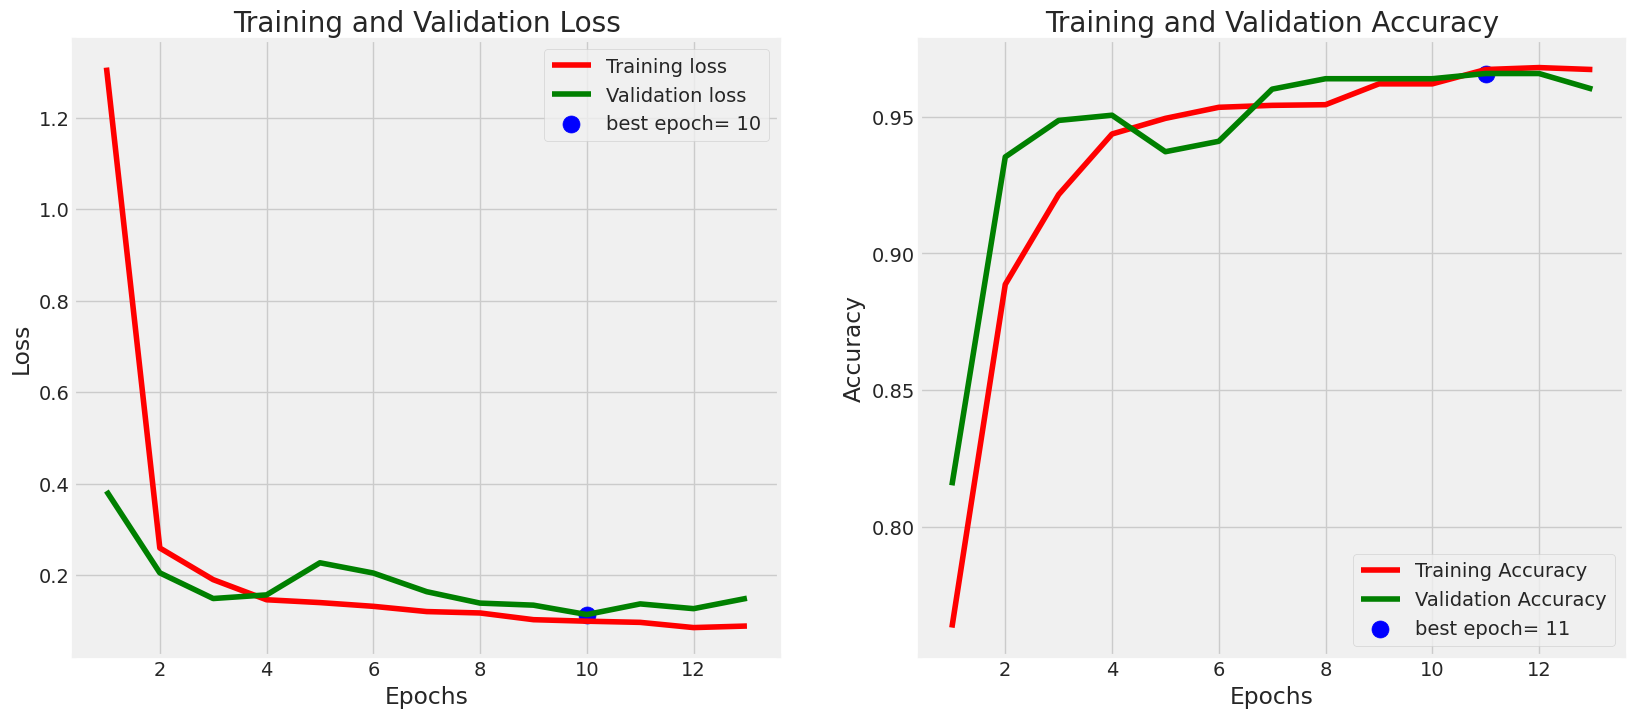

In [15]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [16]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

263/263 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9695 - loss: 0.0909
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9601 - loss: 0.1873
33/33 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.9777 - loss: 0.0832
Train Loss:  0.08894400298595428
Train Accuracy:  0.9707351922988892
--------------------
Validation Loss:  0.14920252561569214
Validation Accuracy:  0.9599999785423279
--------------------
Test Loss:  0.11693349480628967
Test Accuracy:  0.9600760340690613


In [17]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
cm


33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step


array([[150,   3],
       [ 18, 355]])

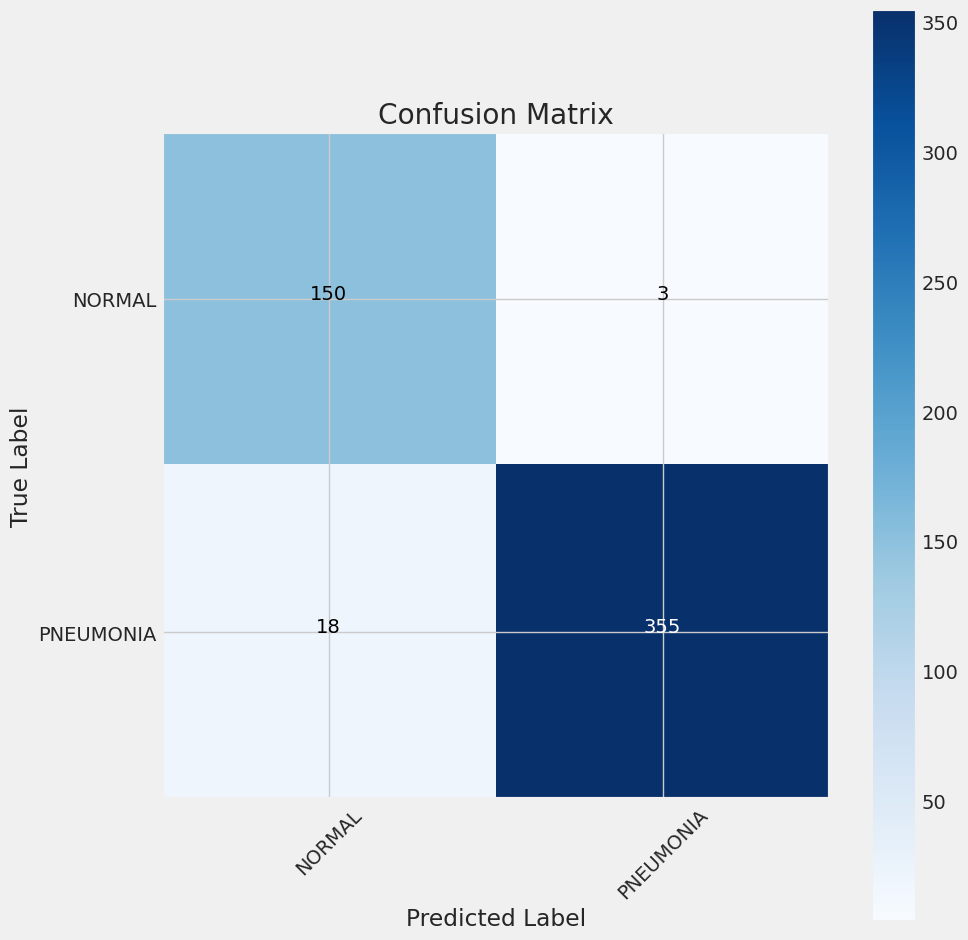

In [18]:

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [19]:
print(classification_report(test_gen.classes,y_pred,target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.89      0.98      0.93       153
   PNEUMONIA       0.99      0.95      0.97       373

    accuracy                           0.96       526
   macro avg       0.94      0.97      0.95       526
weighted avg       0.96      0.96      0.96       526



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


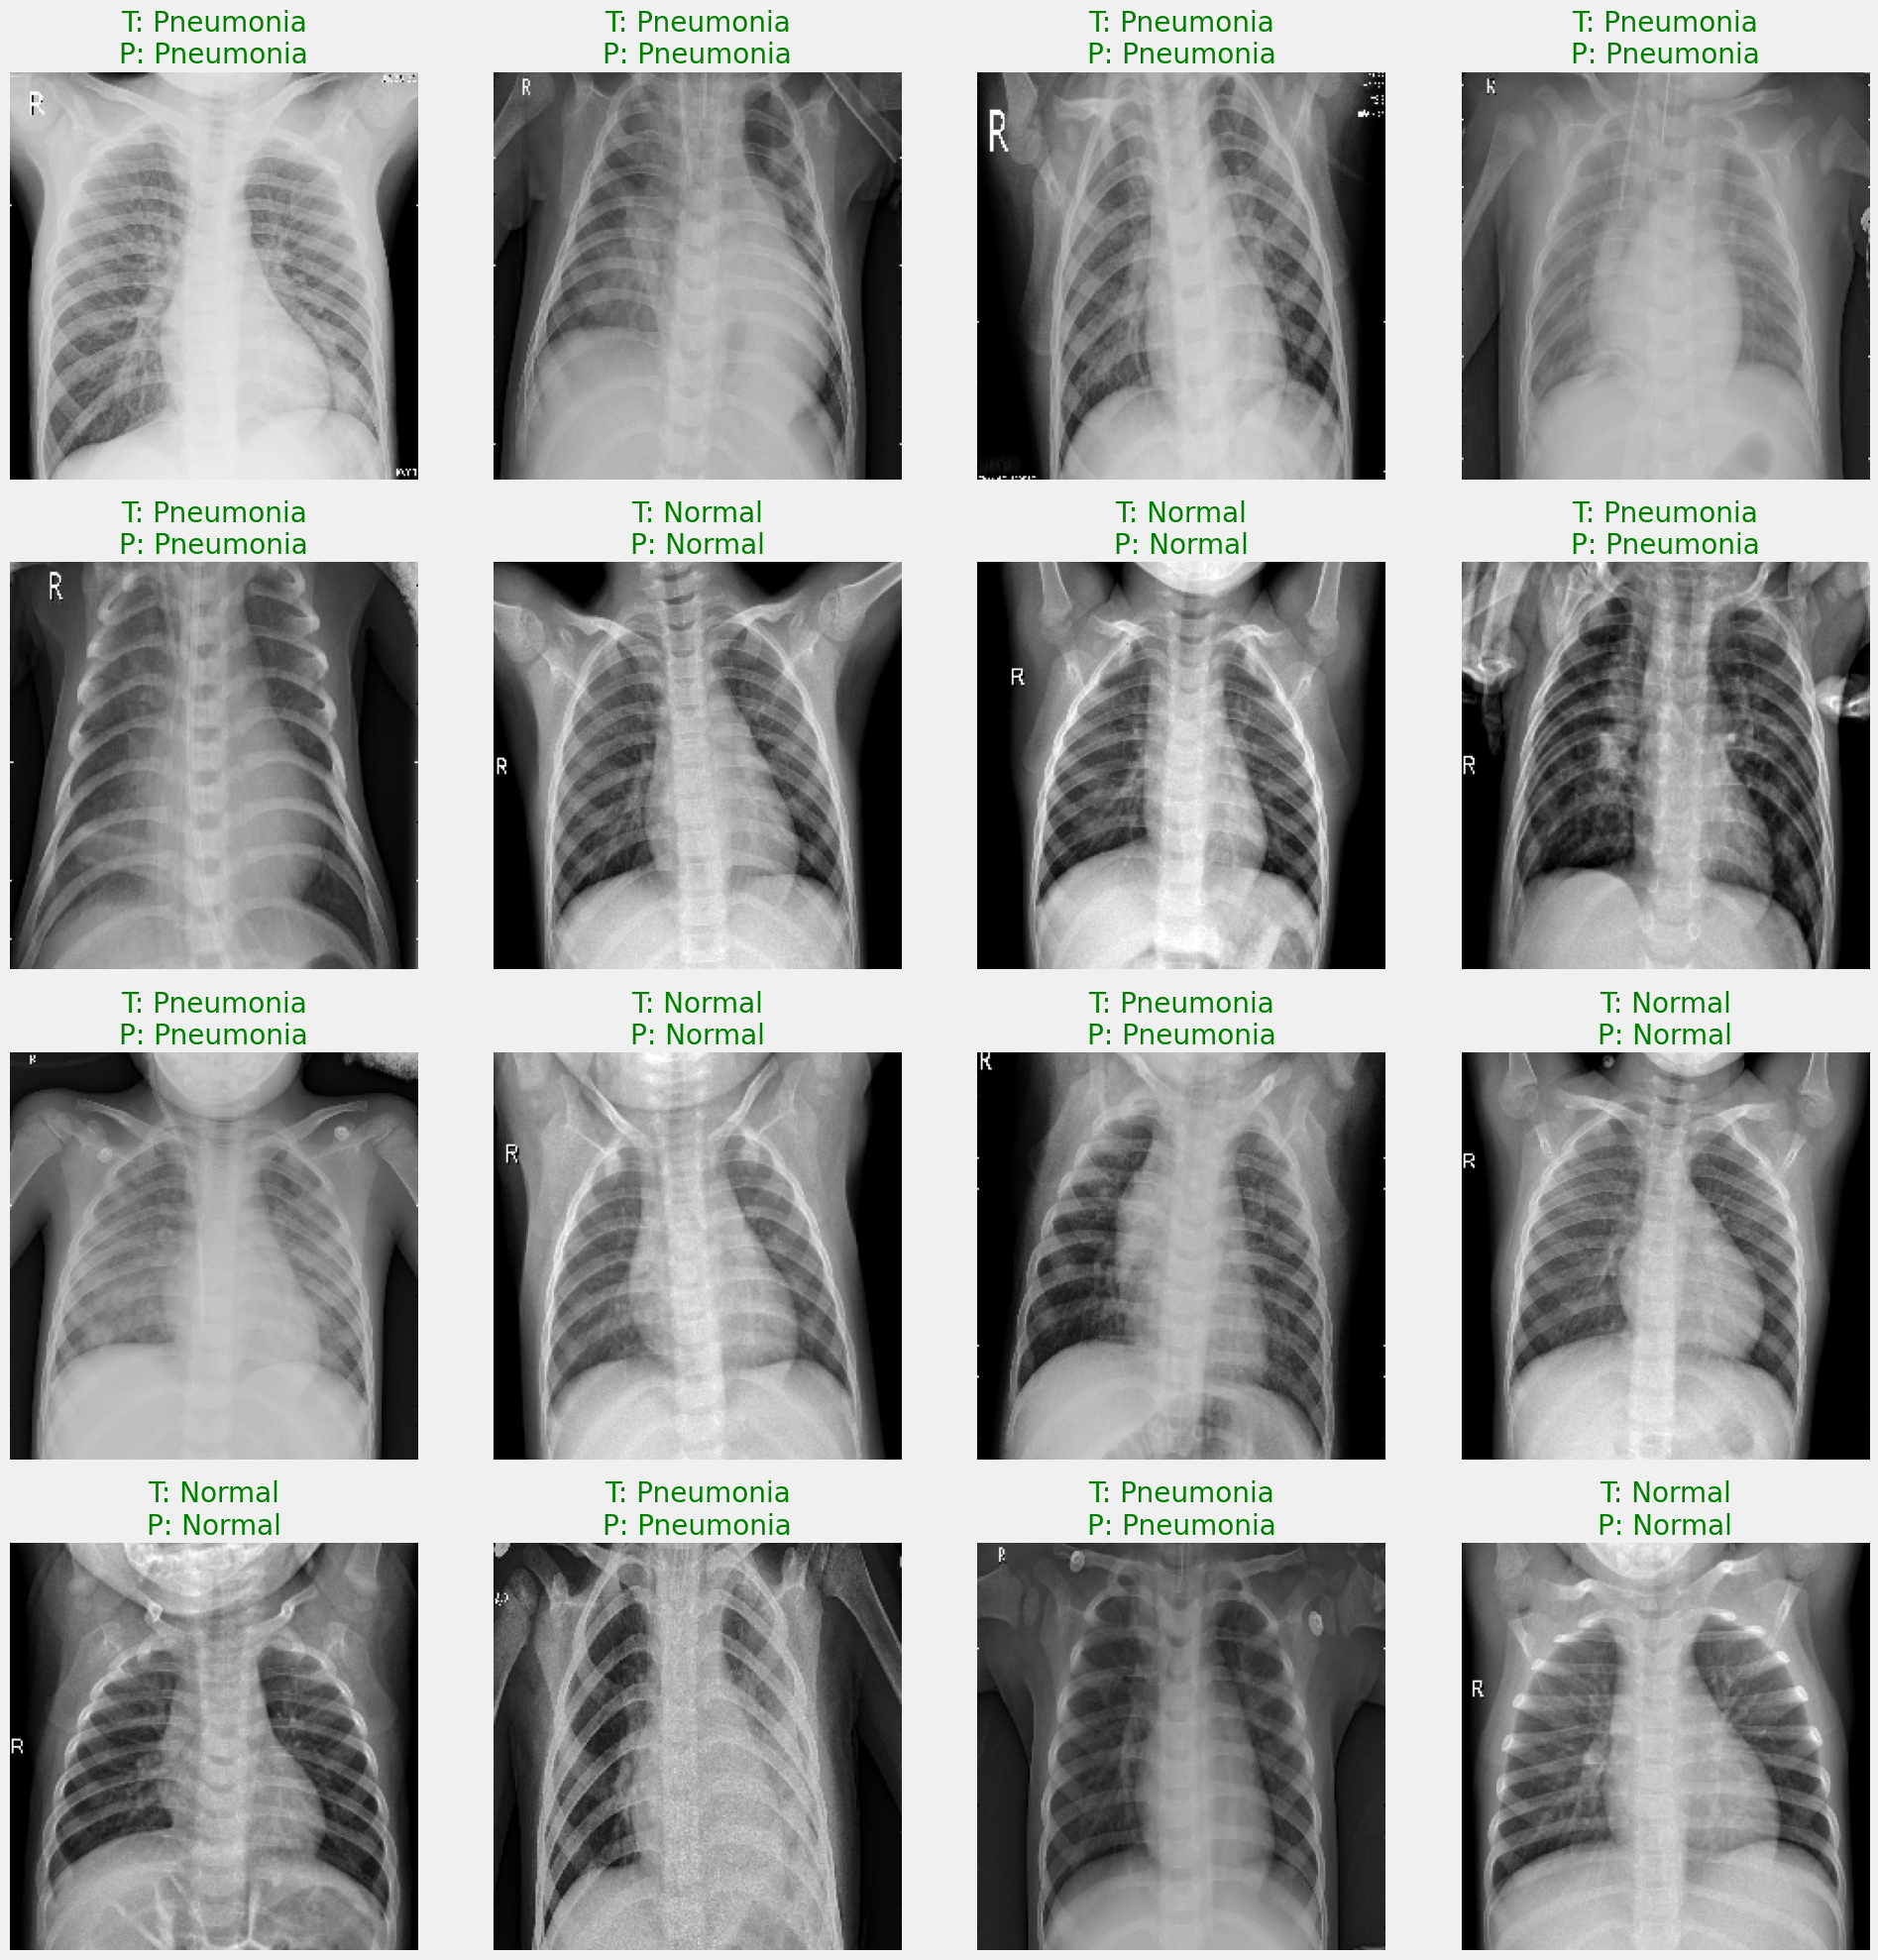

In [20]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ["Normal", "Pneumonia"]

x_test, y_true = next(test_gen)
batch_size = x_test.shape[0]
n_images = min(16, batch_size)

x_test = x_test[:n_images]
y_true = y_true[:n_images]

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

plt.figure(figsize=(20, 20))
for i in range(n_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_test[i].astype("uint8"))
    plt.axis("off")
    true_label = class_names[y_true_classes[i]]
    pred_label = class_names[y_pred_classes[i]]
    plt.title(f"T: {true_label}\nP: {pred_label}", color=("green" if true_label == pred_label else "red"))

plt.tight_layout()
plt.show()


In [21]:
model.save('/content/drive/MyDrive/Dataset/CNN_Pneumonia_new.h5', save_format="tf")